In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from unidecode import unidecode
from datetime import datetime
from fuzzywuzzy import process, fuzz
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from translate import Translator
import re
import dateparser
from gensim import corpora
import gensim

plt.rcParams['figure.figsize'] = (10, 7)

C:\Users\ferna\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def read_file(file):
    '''Reads Whatsapp text file into a list of strings''' 
    x = open(file,'r', encoding = 'utf-8') 
    y = x.read() 
    content = y.splitlines()
    return content

# Pre procesamiento

In [3]:
chat = read_file('whatsapp_comunidad_stgo_centro.txt')
len(chat)

5051

In [5]:
#Sacamos las lineas vacias del chat.
clean_chat = [line for line in chat if len(line) > 1]
print(len(clean_chat))

4933


In [6]:
msgs = [] # contenedor de mensajes
pos = 0 # contador de posición de los mensajes en el contenedor

"""
Flujo:
Por cada línea, verificar si coincide con la expresión que comienza con el formato "número(s) + barra diagonal" ej. "12/"
Si coincide, es una nueva línea de conversación ya que comienza con fechas, añadirla al contenedor de mensajes
De lo contrario, es una continuación de la línea anterior, añadirla a la línea anterior y agregarla a los mensajes, luego eliminar la línea anterior.
"""
for linea in clean_chat:
    if re.findall("\A\d+[/]", linea):
        msgs.append(linea)
        pos += 1
    else:
        concatenado = msgs[pos-1] + ". " + linea
        msgs.append(concatenado)
        msgs.pop(pos-1)
len(msgs)

4644

In [7]:
#Filtra por todo mensaje que no sea un mensaje enviado por un miembro, por lo que aquí se quita mensajes automaticos de whatsapp
#como también las veces
msgs = [message for message in msgs if re.search(r'\-\s(.+?):', message)]

### Extraemos hora, fecha, nombre y mensaje

In [10]:
time = [re.search('\d\s(.+?)\s', msgs[i]).group(1) for i in range(len(msgs))]
time = [s.strip(' ') for s in time] # Quitamos espacios
print(f"length of time is: {len(time)}")
print(time[:5])

length of time is: 4605
['9:22', '9:26', '9:27', '3:00', '3:02']


In [11]:
"""
Al aplicar encoding al chat proveniente la parte de p.m o a.m aún no podía ser decodificada correctamente, 
por lo que se procedió a corregir este problema.
Se creó un diccionario con la correción y se extrajó el caracter 'p' o 'a' y se le hizo match en el diccionario 
para corregir.
"""
time_z = {'p': 'pm', 'a': 'am'}
am_pm = [time_z[re.search(r'\d+:\d+\s([p|a])\.', msgs[i]).group(1)] for i in range(len(msgs))]
print(len(am_pm))
set(am_pm)

4605


{'am', 'pm'}

In [12]:
date = [re.search('(.+?)\s', msgs[i]).group(1) for i in range(len(msgs))]
print("length of time is:")
print(len(date))

length of time is:
4605


In [13]:
name = [re.search(r'\-\s(.+?):', msgs[i]).group(1) for i in range(len(msgs))]
print("length of time is:")
print(len(name))

length of time is:
4605


In [14]:
content = []
for i in range(len(msgs)):
  try:
    content.append(msgs[i].split(':')[2])
  except IndexError:
    content.append('Missing Text')
len(content)

4605

In [15]:
#Ahora con los datos extraidos podemos armar el dataframe
df = pd.DataFrame(list(zip(date, time, am_pm, name, content)), columns = ['Date', 'Time', 'am-pm', 'Name', 'Message'])
df['Message'] = df['Message'].str.lower()

In [16]:
#Se creo esta función para convertir el sistema horario de 12horas a 24horas.
def convert_to_24_hour_format(time, am_pm):
    hour, minute = map(int, time.split(":"))
    if am_pm == "pm" and hour != 12:
        hour += 12
    elif am_pm == "am" and hour == 12:
        hour = 0
    return f"{hour:02d}:{minute:02d}"


In [17]:
df['Traditional_Time'] = df.apply(lambda x: convert_to_24_hour_format(x['Time'], x['am-pm']), axis=1)

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Traditional_Time'])

df['weekday'] = df['DateTime'].apply(lambda x: x.day_name())

df['Hour'] = df['Traditional_Time'].apply(lambda x : x.split(':')[0]) 
df['Month'] = df['Date'].apply(lambda x: int(x.split('/')[1]))
df['Year'] = df['Date'].apply(lambda x: int(x.split('/')[2]))

df['Letter_Count'] = df['Message'].apply(lambda s : len(s))
df['Word_Count'] = df['Message'].apply(lambda s : len(s.split(' ')))

In [18]:
#Esto se realizó para poder tener un heatmap más ordenado y entendible
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday_order'] = pd.Categorical(df['weekday'], categories=day_order, ordered=True)

df = df.sort_values(by='weekday_order')

# Privacidad de datos

> Dado que este chat se extrajó de un grupo de whatsapp comunitario de un edificio de la Región Metropolitana, se elimina la columna "Name", la cual contiene los número de contacto de los miembros.

In [21]:
df.drop('Name', axis=1, inplace=True)

# EDA

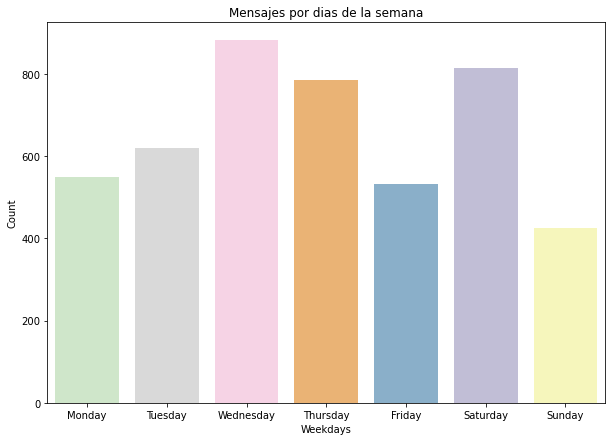

In [23]:
sns.countplot(x='weekday', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                                                       'Saturday', 'Sunday'], palette='Set3_r')
plt.xlabel("Weekdays")
plt.ylabel("Count")
plt.title(f"Mensajes por dias de la semana")
plt.show();

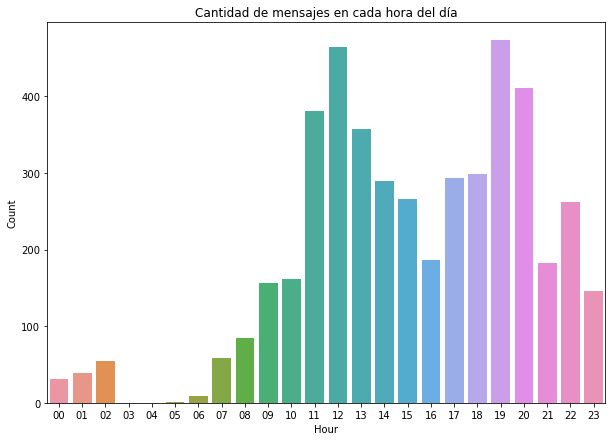

In [24]:
sns.countplot(x='Hour', data=df, order=np.array([str(i).zfill(2) for i in range(24)]))

plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Cantidad de mensajes en cada hora del día")
plt.show();

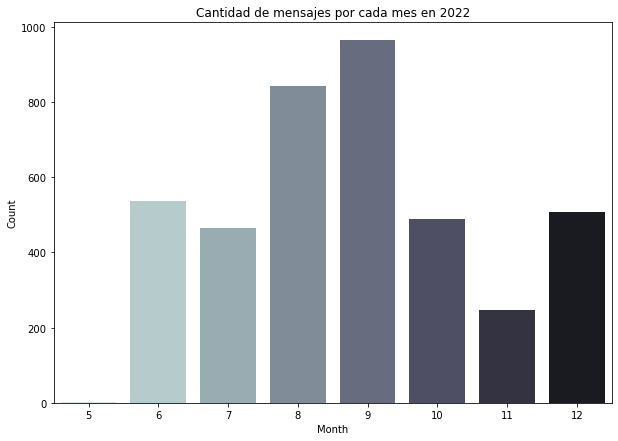

In [25]:
sns.countplot(x='Month', data=df[df['Year'] == 2022], palette='bone_r')
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Cantidad de mensajes por cada mes en 2022")
plt.show();

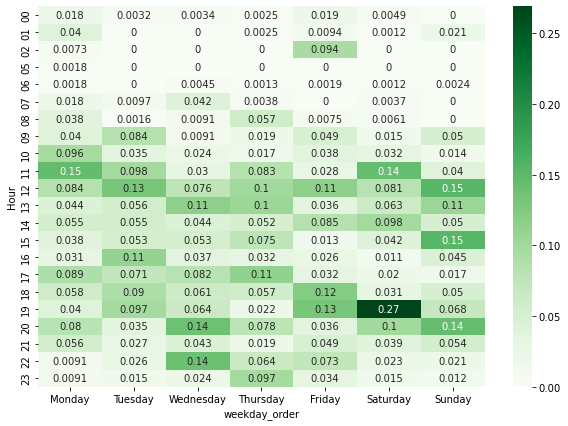

In [26]:
df_grouped = df.groupby(['Hour', 'weekday_order']).size().reset_index(name='Count')
df_grouped_day = df.groupby(['weekday_order']).size().reset_index(name='Count_day')

df_grouped = df_grouped.merge(df_grouped_day, on='weekday_order')
df_grouped['Percentage'] = df_grouped['Count'] / df_grouped['Count_day']
df_pivot = df_grouped.pivot('Hour', 'weekday_order', 'Percentage')

sns.heatmap(df_pivot, annot=True, cmap='Greens');

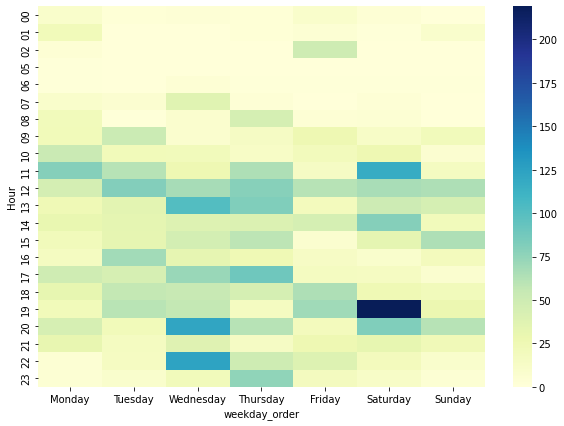

In [27]:
sns.heatmap(pd.crosstab(df['Hour'], df['weekday_order']), cmap="YlGnBu");

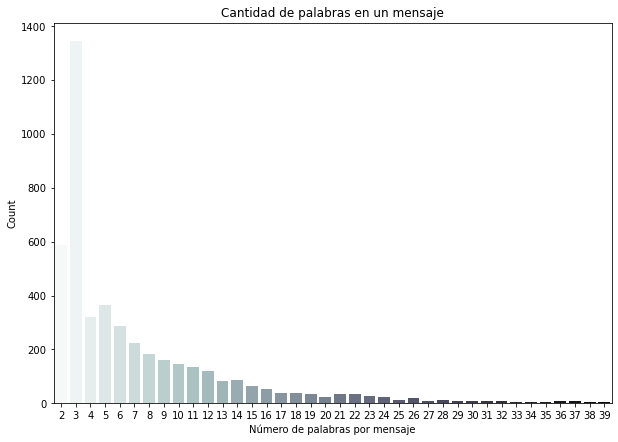

In [26]:
fig, ax = plt.subplots(figsize= (10,7))
sns.countplot(x='Word_Count', data=df[df['Word_Count'] < 40], palette='bone_r')
plt.xlabel("Número de palabras por mensaje")
plt.ylabel("Count")
plt.title("Cantidad de palabras en un mensaje");

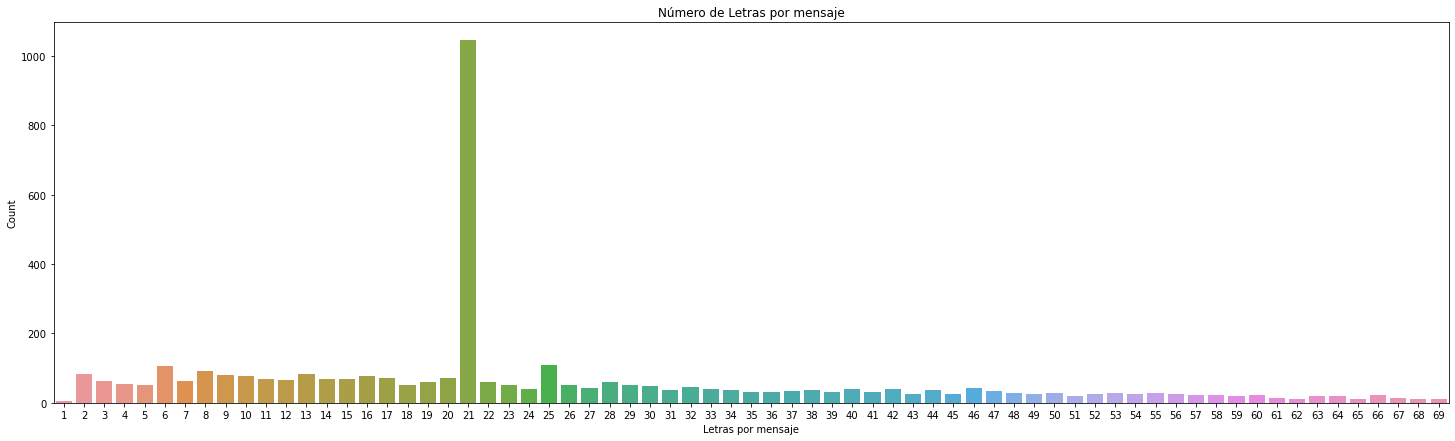

In [27]:
fig, ax = plt.subplots(figsize= (25,7))
sns.countplot(x='Letter_Count', data=df[df['Letter_Count'] < 70])
plt.xlabel("Letras por mensaje")
plt.ylabel("Count")
plt.title("Número de Letras por mensaje");

# Extracción de palabras

In [29]:
tokens = [word_tokenize(message) for message in df['Message']] 

In [30]:
frequency_dist = FreqDist(token for tokens_list in tokens for token in tokens_list)

In [31]:
most_common = frequency_dist.most_common(200)

In [32]:
#Generamos una variable que contiene un diccionario con las palabras sin considerar la frecuencia.
stop_words = set([token for (token, frequency) in most_common])
#Un array con los tweets en listas, pero se filtró por stop words, por lo que ya no estan en los tweets
filtered_tokens = [[token for token in tokens_list if token not in stop_words] for tokens_list in tokens]

In [33]:
filtered_text = [' '.join(tokens_list) for tokens_list in filtered_tokens]
df['filtered_text'] = filtered_text

## Aplicamos un filtro mas complejo para ver si podemos llegar a una extracción de topicos mas refinada

In [50]:
import spacy
nlp = spacy.load('es_core_news_sm')


In [51]:
no_conn_and_prons = []
out_words = []
for message in filtered_text:
    doc = nlp(message)
    connectors_and_pronouns = [token.text for token in doc if token.pos_ not in ["CCONJ", "SCONJ", "PRON", 'ADP', 'ADV', 'AUX', 'X']]
    out_words.append([token.text for token in doc if token.pos_ in ["CCONJ", "SCONJ", "PRON", 'ADP', 'ADV', 'AUX', 'X']])
    
    no_conn_and_prons.append(connectors_and_pronouns)

no_conn_and_prons = [' '.join(tokens_list) for tokens_list in no_conn_and_prons]

In [52]:
df['filtered_text_2'] = no_conn_and_prons

In [53]:
texts =df['filtered_text_2'].apply(lambda x: x.lower().split())

# Topicos

In [54]:
texts =df['filtered_text_2'].apply(lambda x: x.lower().split())

In [55]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [56]:
len(corpus)

4605

In [57]:
num_topics = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)

In [58]:
topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
for i, topic in enumerate(topics):
    print(f'Tópico {i}: {[w[0] for w in topic[1]]}')

Tópico 0: ['🙏', 'vecis', 'respeto', 'tengan', 'sopaipillas', 'invierno', 'gastos', 'conserjería', 'cualquier', 'comunes']
Tópico 1: ['😂', '️', 'sí', 'alarma', 'contacto', 'vendo', 'abierto', 'lastarria', 'pensé', 'llego']
Tópico 2: ['feliz', '.', 'navidad', 'tal', '10', 'cosa', 'orden', 'joven', 'rostro', 'paso']
Tópico 3: ['🍀', '️', '𝐮𝐧𝐢𝐝𝐚𝐝', '❤', '800', '𝐝𝐞', '👏', '😅', '𝟏𝟎𝟎𝟎', '𝟗𝟓𝟎']
Tópico 4: ['🤣', '🥳', 'pasó', 'fuerte', 'internet', 'preste', '20', 'pago', 'noche', 'calle']


# Frecuencia de palabras

> Vamos usar la columna "filetered_text_2"

### Primero quitamos los emojis, emoticones etc..

In [69]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticones
                               u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
                               u"\U0001F680-\U0001F6FF"  # transporte y símbolos de mapas
                               u"\U0001F1E0-\U0001F1FF"  # banderas de países
                               u"\U00002600-\U000027BF"  # emoticones varios
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"  # emoticones y símbolos diversos
                               u"\u200d"  # caracteres de unión
                               u"\u2640-\u2642"  # símbolos de género
                               u"\u25a0"  # símbolos de formas geométricas
                               "]+", flags=re.UNICODE)
    

    text_without_emojis = emoji_pattern.sub(r'', text)
    
    return text_without_emojis

df['filtered_text_2_no_emojis'] = df['filtered_text_2'].apply(remove_emojis)


In [70]:
tokens = [word_tokenize(message) for message in df['filtered_text_2_no_emojis']] 

In [71]:
frequency_dist = FreqDist(token for tokens_list in tokens for token in tokens_list)

> Como podemos ver se nos pasó un caracter extraño, probablemente un emoticon no identificado en los patrones anteriores, así que lo eliminamos

In [77]:
frequency_dist 

FreqDist({'️': 81, '.': 26, 'arriendo': 18, 'algun': 18, 'unas': 18, 'cuidado': 18, 'vecis': 18, 'super': 18, 'claro': 18, 'conserjería': 18, ...})

In [85]:
excluded_value = '️'
excluded_freq = frequency_dist[excluded_value]

frequency_dist.subtract({excluded_value: excluded_freq})
print(frequency_dist)

<FreqDist with 5213 samples and 11158 outcomes>


In [86]:
from wordcloud import WordCloud

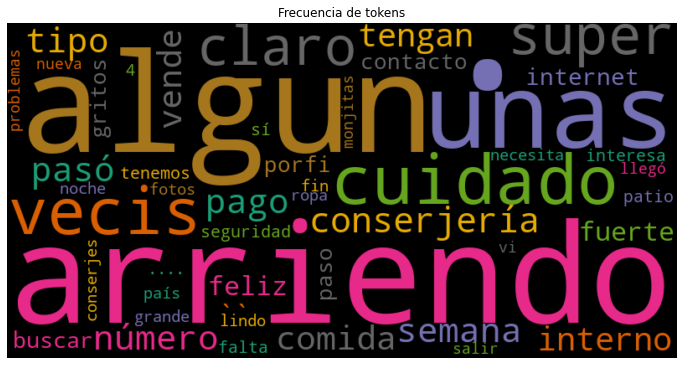

In [87]:
wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=50, relative_scaling=0.5, colormap='Dark2')

wordcloud.generate_from_frequencies(frequency_dist)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frecuencia de tokens')
plt.show()